In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.decomposition import IncrementalPCA
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import RFE

import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor

import warnings
warnings.filterwarnings('ignore')

## 1. Reading & understanding the data

In [2]:
ds_telecom = pd.read_csv('telecom_churn_data.csv')

In [3]:
ds_telecom.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.385,...,0,1.0,1.0,1.0,NaN,968,30.4,0.0,101.20,3.58
1,7001865778,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.047,...,0,NaN,1.0,1.0,NaN,1006,0.0,0.0,0.00,0.00
2,7001625959,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.690,...,0,NaN,NaN,NaN,1.0,1103,0.0,0.0,4.17,0.00
3,7001204172,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.338,...,0,NaN,NaN,NaN,NaN,2491,0.0,0.0,0.00,0.00
4,7000142493,109,0.0,0.0,0.0,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.636,...,0,0.0,NaN,NaN,NaN,1526,0.0,0.0,0.00,0.00


In [4]:
ds_telecom.shape

(99999, 226)

In [5]:
ds_telecom.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99999 entries, 0 to 99998
Data columns (total 226 columns):
 #    Column                    Dtype  
---   ------                    -----  
 0    mobile_number             int64  
 1    circle_id                 int64  
 2    loc_og_t2o_mou            float64
 3    std_og_t2o_mou            float64
 4    loc_ic_t2o_mou            float64
 5    last_date_of_month_6      object 
 6    last_date_of_month_7      object 
 7    last_date_of_month_8      object 
 8    last_date_of_month_9      object 
 9    arpu_6                    float64
 10   arpu_7                    float64
 11   arpu_8                    float64
 12   arpu_9                    float64
 13   onnet_mou_6               float64
 14   onnet_mou_7               float64
 15   onnet_mou_8               float64
 16   onnet_mou_9               float64
 17   offnet_mou_6              float64
 18   offnet_mou_7              float64
 19   offnet_mou_8              float64
 20   offn

In [6]:
ds_telecom.describe()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
count,9.999900e+04,99999.0,98981.0,98981.0,98981.0,99999.000000,99999.000000,99999.000000,99999.000000,96062.000000,...,99999.000000,25153.000000,25571.000000,26339.000000,25922.000000,99999.000000,99999.000000,99999.000000,99999.000000,99999.000000
mean,7.001207e+09,109.0,0.0,0.0,0.0,282.987358,278.536648,279.154731,261.645069,132.395875,...,0.084581,0.914404,0.908764,0.890808,0.860968,1219.854749,68.170248,66.839062,60.021204,3.299373
std,6.956694e+05,0.0,0.0,0.0,0.0,328.439770,338.156291,344.474791,341.998630,297.207406,...,0.650457,0.279772,0.287950,0.311885,0.345987,954.733842,267.580450,271.201856,253.938223,32.408353
min,7.000000e+09,109.0,0.0,0.0,0.0,-2258.709000,-2014.045000,-945.808000,-1899.505000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,180.000000,0.000000,0.000000,0.000000,0.000000
25%,7.000606e+09,109.0,0.0,0.0,0.0,93.411500,86.980500,84.126000,62.685000,7.380000,...,0.000000,1.000000,1.000000,1.000000,1.000000,467.000000,0.000000,0.000000,0.000000,0.000000
50%,7.001205e+09,109.0,0.0,0.0,0.0,197.704000,191.640000,192.080000,176.849000,34.310000,...,0.000000,1.000000,1.000000,1.000000,1.000000,863.000000,0.000000,0.000000,0.000000,0.000000
75%,7.001812e+09,109.0,0.0,0.0,0.0,371.060000,365.344500,369.370500,353.466500,118.740000,...,0.000000,1.000000,1.000000,1.000000,1.000000,1807.500000,0.000000,0.000000,0.000000,0.000000
max,7.002411e+09,109.0,0.0,0.0,0.0,27731.088000,35145.834000,33543.624000,38805.617000,7376.710000,...,49.000000,1.000000,1.000000,1.000000,1.000000,4337.000000,12916.220000,9165.600000,11166.210000,2618.570000


## 2. Preparing the data

Missing values

In [9]:
ds_mv = (round(((ds_telecom.isnull().sum()/len(ds_telecom.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
ds_mv

,null
arpu_3g_6,74.85
night_pck_user_6,74.85
total_rech_data_6,74.85
arpu_2g_6,74.85
max_rech_data_6,74.85
...,...
max_rech_amt_7,0.00
max_rech_amt_6,0.00
total_rech_amt_9,0.00
total_rech_amt_8,0.00


Columns with more than 30% data missing

In [11]:
ds_mv30 = list(ds_mv.index[ds_mv['null'] > 30])

Deleting columns with more than 30% data missing

In [13]:
ds_telecom = ds_telecom.drop(ds_mv30, axis=1)

In [14]:
ds_telecom.shape

(99999, 186)

Dropping dates column

In [16]:
date_cols = [k for k in ds_telecom.columns.to_list() if 'date' in k]
print(date_cols)

['last_date_of_month_6', 'last_date_of_month_7', 'last_date_of_month_8', 'last_date_of_month_9', 'date_of_last_rech_6', 'date_of_last_rech_7', 'date_of_last_rech_8', 'date_of_last_rech_9']


In [17]:
ds_telecom = ds_telecom.drop(date_cols, axis=1)

The circle_id column may not be as useful given it has 1 unique value across

In [19]:
ds_telecom = ds_telecom.drop('circle_id', axis=1)

In [20]:
ds_telecom.shape

(99999, 177)

Let us now filter te high value costomers - Sum up the total recharges

In [22]:
ds_telecom['avg_rech_amt_6_7'] = (ds_telecom['total_rech_amt_6'] + ds_telecom['total_rech_amt_7'])/2

70th percentile

In [24]:
P_70 = ds_telecom['avg_rech_amt_6_7'].quantile(0.7)
P_70

368.5

Amount of customers who recharged more than P_70

In [26]:
ds_telecom = ds_telecom[ds_telecom['avg_rech_amt_6_7'] >= P_70]
ds_telecom.head()

,mobile_number,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_rech_amt_6_7
7,7000701601,0.0,0.0,0.0,1069.180,1349.850,3171.480,500.000,57.84,54.68,...,0,0,0,0,802,57.74,19.38,18.74,0.0,1185.0
8,7001524846,0.0,0.0,0.0,378.721,492.223,137.362,166.787,413.69,351.03,...,0,0,0,0,315,21.03,910.65,122.16,0.0,519.0
13,7002191713,0.0,0.0,0.0,492.846,205.671,593.260,322.732,501.76,108.39,...,0,0,0,0,2607,0.00,0.00,0.00,0.0,380.0
16,7000875565,0.0,0.0,0.0,430.975,299.869,187.894,206.490,50.51,74.01,...,0,0,0,0,511,0.00,2.45,21.89,0.0,459.0
17,7000187447,0.0,0.0,0.0,690.008,18.980,25.499,257.583,1185.91,9.28,...,0,0,0,0,667,0.00,0.00,0.00,0.0,408.0


In [27]:
ds_telecom.shape

(30011, 178)

We are now down to 30% of the total data after filtering

Handling rows with missing value

In [30]:
ds_mr = ds_telecom[(ds_telecom.isnull().sum(axis=1)) > (len(ds_telecom.columns)//2)]
ds_mr.shape

(114, 178)

In [31]:
ds_telecom = ds_telecom.drop(ds_mr.index)
ds_telecom.shape

(29897, 178)

In [32]:
ds_mc1 = (round(((ds_telecom.isnull().sum()/len(ds_telecom.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
ds_mc1

,null
loc_ic_mou_9,5.32
og_others_9,5.32
loc_og_t2t_mou_9,5.32
loc_ic_t2t_mou_9,5.32
loc_og_t2m_mou_9,5.32
...,...
max_rech_amt_7,0.00
max_rech_amt_8,0.00
max_rech_amt_9,0.00
last_day_rch_amt_6,0.00


Listing the columns of MOU Sep(9)

In [34]:
print(((ds_mc1[ds_mc1['null'] == 5.32]).index).to_list())

['loc_ic_mou_9', 'og_others_9', 'loc_og_t2t_mou_9', 'loc_ic_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'std_ic_t2m_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'roam_og_mou_9', 'std_ic_t2o_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'spl_og_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'std_ic_t2t_mou_9', 'std_ic_mou_9', 'onnet_mou_9', 'spl_ic_mou_9', 'ic_others_9', 'isd_ic_mou_9', 'loc_ic_t2f_mou_9', 'offnet_mou_9', 'loc_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'roam_ic_mou_9']


In [35]:
ds_null_mou_9 = ds_telecom[(ds_telecom['loc_og_t2m_mou_9'].isnull()) & (ds_telecom['loc_ic_t2f_mou_9'].isnull()) & (ds_telecom['roam_og_mou_9'].isnull()) & (ds_telecom['std_ic_t2m_mou_9'].isnull()) &
  (ds_telecom['loc_og_t2t_mou_9'].isnull()) & (ds_telecom['std_ic_t2t_mou_9'].isnull()) & (ds_telecom['loc_og_t2f_mou_9'].isnull()) & (ds_telecom['loc_ic_mou_9'].isnull()) &
  (ds_telecom['loc_og_t2c_mou_9'].isnull()) & (ds_telecom['loc_og_mou_9'].isnull()) & (ds_telecom['std_og_t2t_mou_9'].isnull()) & (ds_telecom['roam_ic_mou_9'].isnull()) &
  (ds_telecom['loc_ic_t2m_mou_9'].isnull()) & (ds_telecom['std_og_t2m_mou_9'].isnull()) & (ds_telecom['loc_ic_t2t_mou_9'].isnull()) & (ds_telecom['std_og_t2f_mou_9'].isnull()) & 
  (ds_telecom['std_og_t2c_mou_9'].isnull()) & (ds_telecom['og_others_9'].isnull()) & (ds_telecom['std_og_mou_9'].isnull()) & (ds_telecom['spl_og_mou_9'].isnull()) & 
  (ds_telecom['std_ic_t2f_mou_9'].isnull()) & (ds_telecom['isd_og_mou_9'].isnull()) & (ds_telecom['std_ic_mou_9'].isnull()) & (ds_telecom['offnet_mou_9'].isnull()) & 
  (ds_telecom['isd_ic_mou_9'].isnull()) & (ds_telecom['ic_others_9'].isnull()) & (ds_telecom['std_ic_t2o_mou_9'].isnull()) & (ds_telecom['onnet_mou_9'].isnull()) & 
  (ds_telecom['spl_ic_mou_9'].isnull())]

ds_null_mou_9.head()

,mobile_number,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_rech_amt_6_7
7,7000701601,0.0,0.0,0.0,1069.180,1349.850,3171.480,500.0,57.84,54.68,...,0,0,0,0,802,57.74,19.38,18.74,0.0,1185.0
97,7000589828,0.0,0.0,0.0,374.863,294.023,183.043,0.0,433.59,415.66,...,0,0,0,0,502,0.00,0.00,0.00,0.0,380.0
111,7001300706,0.0,0.0,0.0,596.301,146.073,0.000,0.0,55.19,3.26,...,1,0,0,0,332,0.00,0.00,0.00,0.0,441.0
143,7000106299,0.0,0.0,0.0,695.609,39.981,0.000,0.0,1325.91,28.61,...,0,0,0,0,264,0.00,0.00,0.00,0.0,418.0
188,7000340381,0.0,0.0,0.0,734.641,183.668,0.000,0.0,4.38,0.98,...,0,0,0,0,244,0.00,831.48,1223.04,0.0,492.0


In [36]:
ds_null_mou_9.shape

(1590, 178)

In [37]:
ds_telecom = ds_telecom.drop(ds_null_mou_9.index)

In [38]:
ds_mc2 = (round(((ds_telecom.isnull().sum()/len(ds_telecom.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
ds_mc2

,null
isd_og_mou_8,0.55
roam_ic_mou_8,0.55
loc_og_mou_8,0.55
std_ic_t2o_mou_8,0.55
roam_og_mou_8,0.55
...,...
total_og_mou_9,0.00
total_og_mou_8,0.00
total_og_mou_7,0.00
total_og_mou_6,0.00


Let us now check the records for August and fix data where needed since August also has missing values

In [40]:
print(((ds_mc2[ds_mc2['null'] == 0.55]).index).to_list())

['isd_og_mou_8', 'roam_ic_mou_8', 'loc_og_mou_8', 'std_ic_t2o_mou_8', 'roam_og_mou_8', 'loc_ic_t2f_mou_8', 'loc_og_t2t_mou_8', 'std_ic_t2f_mou_8', 'std_og_t2m_mou_8', 'loc_og_t2m_mou_8', 'std_og_t2t_mou_8', 'std_ic_t2m_mou_8', 'loc_og_t2f_mou_8', 'spl_og_mou_8', 'loc_ic_mou_8', 'loc_og_t2c_mou_8', 'std_ic_t2t_mou_8', 'loc_ic_t2m_mou_8', 'std_og_t2f_mou_8', 'spl_ic_mou_8', 'std_ic_mou_8', 'offnet_mou_8', 'ic_others_8', 'og_others_8', 'loc_ic_t2t_mou_8', 'onnet_mou_8', 'isd_ic_mou_8', 'std_og_t2c_mou_8', 'std_og_mou_8']


In [41]:
ds_null_mou_8 = ds_telecom[(ds_telecom['loc_og_t2m_mou_8'].isnull()) & (ds_telecom['loc_ic_t2f_mou_8'].isnull()) & (ds_telecom['roam_og_mou_8'].isnull()) & (ds_telecom['std_ic_t2m_mou_8'].isnull()) &
  (ds_telecom['loc_og_t2t_mou_8'].isnull()) & (ds_telecom['std_ic_t2t_mou_8'].isnull()) & (ds_telecom['loc_og_t2f_mou_8'].isnull()) & (ds_telecom['loc_ic_mou_8'].isnull()) &
  (ds_telecom['loc_og_t2c_mou_8'].isnull()) & (ds_telecom['loc_og_mou_8'].isnull()) & (ds_telecom['std_og_t2t_mou_8'].isnull()) & (ds_telecom['roam_ic_mou_8'].isnull()) &
  (ds_telecom['loc_ic_t2m_mou_8'].isnull()) & (ds_telecom['std_og_t2m_mou_8'].isnull()) & (ds_telecom['loc_ic_t2t_mou_8'].isnull()) & (ds_telecom['std_og_t2f_mou_8'].isnull()) & 
  (ds_telecom['std_og_t2c_mou_8'].isnull()) & (ds_telecom['og_others_8'].isnull()) & (ds_telecom['std_og_mou_8'].isnull()) & (ds_telecom['spl_og_mou_8'].isnull()) & 
  (ds_telecom['std_ic_t2f_mou_8'].isnull()) & (ds_telecom['isd_og_mou_8'].isnull()) & (ds_telecom['std_ic_mou_8'].isnull()) & (ds_telecom['offnet_mou_8'].isnull()) & 
  (ds_telecom['isd_ic_mou_8'].isnull()) & (ds_telecom['ic_others_8'].isnull()) & (ds_telecom['std_ic_t2o_mou_8'].isnull()) & (ds_telecom['onnet_mou_8'].isnull()) & 
  (ds_telecom['spl_ic_mou_8'].isnull())]

In [42]:
ds_null_mou_8.head()

,mobile_number,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_rech_amt_6_7
375,7002252754,0.0,0.0,0.0,580.477,111.878,0.0,378.881,249.43,39.64,...,0,0,0,0,1102,0.0,0.0,0.0,0.0,415.0
578,7000248548,0.0,0.0,0.0,569.612,237.289,0.0,4.440,718.01,212.73,...,0,0,0,0,274,0.0,0.0,0.0,0.0,468.5
788,7000636808,0.0,0.0,0.0,532.742,546.756,0.0,269.274,1173.39,891.83,...,0,0,0,0,936,0.0,0.0,0.0,0.0,604.0
1802,7000516213,0.0,0.0,0.0,810.455,0.000,0.0,0.000,91.33,NaN,...,0,0,0,0,755,0.0,0.0,0.0,0.0,477.5
4837,7002192662,0.0,0.0,0.0,649.150,149.572,0.0,0.250,1354.24,85.13,...,0,0,0,0,520,0.0,0.0,0.0,0.0,421.0


In [43]:
ds_telecom = ds_telecom.drop(ds_null_mou_8.index)

In [44]:
ds_mc3 = (round(((ds_telecom.isnull().sum()/len(ds_telecom.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
ds_mc3

,null
roam_ic_mou_6,0.44
spl_og_mou_6,0.44
og_others_6,0.44
loc_ic_t2t_mou_6,0.44
loc_og_t2m_mou_6,0.44
...,...
isd_og_mou_9,0.00
isd_og_mou_8,0.00
std_og_mou_9,0.00
std_og_mou_8,0.00


In [45]:
print(((ds_mc3[ds_mc3['null'] == 0.44]).index).to_list())

['roam_ic_mou_6', 'spl_og_mou_6', 'og_others_6', 'loc_ic_t2t_mou_6', 'loc_og_t2m_mou_6', 'loc_og_t2c_mou_6', 'loc_ic_t2m_mou_6', 'isd_og_mou_6', 'loc_og_t2t_mou_6', 'std_og_t2m_mou_6', 'loc_ic_t2f_mou_6', 'ic_others_6', 'roam_og_mou_6', 'loc_ic_mou_6', 'std_og_mou_6', 'loc_og_t2f_mou_6', 'isd_ic_mou_6', 'std_ic_t2t_mou_6', 'std_ic_mou_6', 'std_og_t2t_mou_6', 'std_ic_t2o_mou_6', 'std_og_t2f_mou_6', 'std_ic_t2f_mou_6', 'spl_ic_mou_6', 'onnet_mou_6', 'std_og_t2c_mou_6', 'std_ic_t2m_mou_6', 'offnet_mou_6', 'loc_og_mou_6']


In [46]:
ds_null_mou_6 = ds_telecom[(ds_telecom['loc_og_t2m_mou_6'].isnull()) & (ds_telecom['loc_ic_t2f_mou_6'].isnull()) & (ds_telecom['roam_og_mou_6'].isnull()) & (ds_telecom['std_ic_t2m_mou_6'].isnull()) &
  (ds_telecom['loc_og_t2t_mou_6'].isnull()) & (ds_telecom['std_ic_t2t_mou_6'].isnull()) & (ds_telecom['loc_og_t2f_mou_6'].isnull()) & (ds_telecom['loc_ic_mou_6'].isnull()) &
  (ds_telecom['loc_og_t2c_mou_6'].isnull()) & (ds_telecom['loc_og_mou_6'].isnull()) & (ds_telecom['std_og_t2t_mou_6'].isnull()) & (ds_telecom['roam_ic_mou_6'].isnull()) &
  (ds_telecom['loc_ic_t2m_mou_6'].isnull()) & (ds_telecom['std_og_t2m_mou_6'].isnull()) & (ds_telecom['loc_ic_t2t_mou_6'].isnull()) & (ds_telecom['std_og_t2f_mou_6'].isnull()) & 
  (ds_telecom['std_og_t2c_mou_6'].isnull()) & (ds_telecom['og_others_6'].isnull()) & (ds_telecom['std_og_mou_6'].isnull()) & (ds_telecom['spl_og_mou_6'].isnull()) & 
  (ds_telecom['std_ic_t2f_mou_6'].isnull()) & (ds_telecom['isd_og_mou_6'].isnull()) & (ds_telecom['std_ic_mou_6'].isnull()) & (ds_telecom['offnet_mou_6'].isnull()) & 
  (ds_telecom['isd_ic_mou_6'].isnull()) & (ds_telecom['ic_others_6'].isnull()) & (ds_telecom['std_ic_t2o_mou_6'].isnull()) & (ds_telecom['onnet_mou_6'].isnull()) & 
  (ds_telecom['spl_ic_mou_6'].isnull())]

ds_null_mou_6.head()

,mobile_number,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_rech_amt_6_7
77,7001328263,0.0,0.0,0.0,30.000,82.378,674.950,158.710,NaN,34.23,...,0,0,0,0,1894,0.00,0.00,0.00,0.00,577.0
364,7002168045,0.0,0.0,0.0,0.000,792.112,989.368,923.040,NaN,433.49,...,0,0,1,0,424,0.00,0.00,0.00,0.00,485.0
423,7000635248,0.0,0.0,0.0,213.802,304.194,149.710,329.643,NaN,0.00,...,0,0,0,0,945,73.55,266.94,63.04,0.00,421.5
934,7002152278,0.0,0.0,0.0,48.000,764.152,500.030,194.400,NaN,14.24,...,0,0,2,1,490,188.83,215.00,0.00,24.18,651.0
1187,7000486275,0.0,0.0,0.0,0.000,757.170,995.719,0.000,NaN,1366.71,...,0,0,0,0,737,0.00,0.00,0.00,0.00,441.5


In [47]:
ds_telecom = ds_telecom.drop(ds_null_mou_6.index)

In [48]:
ds_mc4 = (round(((ds_telecom.isnull().sum()/len(ds_telecom.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
ds_mc4

,null
loc_ic_t2f_mou_7,0.12
isd_ic_mou_7,0.12
loc_og_t2f_mou_7,0.12
loc_og_t2c_mou_7,0.12
loc_og_mou_7,0.12
...,...
spl_og_mou_6,0.00
spl_og_mou_8,0.00
spl_og_mou_9,0.00
og_others_6,0.00


In [49]:
print(((ds_mc4[ds_mc4['null'] == 0.12]).index).to_list())

['loc_ic_t2f_mou_7', 'isd_ic_mou_7', 'loc_og_t2f_mou_7', 'loc_og_t2c_mou_7', 'loc_og_mou_7', 'std_og_t2t_mou_7', 'std_og_t2f_mou_7', 'std_og_t2c_mou_7', 'std_og_mou_7', 'ic_others_7', 'isd_og_mou_7', 'spl_og_mou_7', 'loc_og_t2t_mou_7', 'og_others_7', 'spl_ic_mou_7', 'loc_ic_t2t_mou_7', 'std_ic_mou_7', 'loc_ic_t2m_mou_7', 'std_ic_t2o_mou_7', 'std_ic_t2f_mou_7', 'loc_ic_mou_7', 'std_ic_t2t_mou_7', 'loc_og_t2m_mou_7', 'std_og_t2m_mou_7', 'std_ic_t2m_mou_7', 'roam_ic_mou_7', 'onnet_mou_7', 'roam_og_mou_7', 'offnet_mou_7']


In [50]:
ds_null_mou_7 = ds_telecom[(ds_telecom['loc_og_t2m_mou_7'].isnull()) & (ds_telecom['loc_ic_t2f_mou_7'].isnull()) & (ds_telecom['roam_og_mou_7'].isnull()) & (ds_telecom['std_ic_t2m_mou_7'].isnull()) &
  (ds_telecom['loc_og_t2t_mou_7'].isnull()) & (ds_telecom['std_ic_t2t_mou_7'].isnull()) & (ds_telecom['loc_og_t2f_mou_7'].isnull()) & (ds_telecom['loc_ic_mou_7'].isnull()) &
  (ds_telecom['loc_og_t2c_mou_7'].isnull()) & (ds_telecom['loc_og_mou_7'].isnull()) & (ds_telecom['std_og_t2t_mou_7'].isnull()) & (ds_telecom['roam_ic_mou_7'].isnull()) &
  (ds_telecom['loc_ic_t2m_mou_7'].isnull()) & (ds_telecom['std_og_t2m_mou_7'].isnull()) & (ds_telecom['loc_ic_t2t_mou_7'].isnull()) & (ds_telecom['std_og_t2f_mou_7'].isnull()) & 
  (ds_telecom['std_og_t2c_mou_7'].isnull()) & (ds_telecom['og_others_7'].isnull()) & (ds_telecom['std_og_mou_7'].isnull()) & (ds_telecom['spl_og_mou_7'].isnull()) & 
  (ds_telecom['std_ic_t2f_mou_7'].isnull()) & (ds_telecom['isd_og_mou_7'].isnull()) & (ds_telecom['std_ic_mou_7'].isnull()) & (ds_telecom['offnet_mou_7'].isnull()) & 
  (ds_telecom['isd_ic_mou_7'].isnull()) & (ds_telecom['ic_others_7'].isnull()) & (ds_telecom['std_ic_t2o_mou_7'].isnull()) & (ds_telecom['onnet_mou_7'].isnull()) & 
  (ds_telecom['spl_ic_mou_7'].isnull())]

ds_null_mou_7.head()

,mobile_number,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,...,sachet_3g_6,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_rech_amt_6_7
5616,7001238202,0.0,0.0,0.0,760.815,531.088,992.818,1144.676,324.91,NaN,...,0,0,0,0,576,63.38,0.0,0.0,163.39,778.0
9451,7001477649,0.0,0.0,0.0,1129.566,0.000,128.252,802.648,11.89,NaN,...,0,0,0,0,672,0.00,0.0,0.0,0.00,603.0
9955,7001658068,0.0,0.0,0.0,925.028,189.000,789.761,445.707,46.39,NaN,...,0,0,0,0,3107,0.00,0.0,0.0,0.00,692.5
10724,7001391499,0.0,0.0,0.0,894.818,85.000,207.040,363.314,117.21,NaN,...,0,0,0,0,2664,0.00,0.0,0.0,0.00,510.0
12107,7000131738,0.0,0.0,0.0,1803.475,0.000,0.600,25.243,1742.61,NaN,...,0,0,0,0,219,0.00,0.0,0.0,0.00,995.0


In [51]:
ds_telecom = ds_telecom.drop(ds_null_mou_7.index)

In [52]:
ds_mc5 = (round(((ds_telecom.isnull().sum()/len(ds_telecom.index))*100),2).to_frame('null')).sort_values('null', ascending=False)
ds_mc5

,null
mobile_number,0.0
total_rech_num_7,0.0
std_ic_mou_7,0.0
std_ic_mou_8,0.0
std_ic_mou_9,0.0
...,...
std_og_mou_7,0.0
std_og_mou_8,0.0
std_og_mou_9,0.0
isd_og_mou_6,0.0


In [53]:
ds_telecom.shape

(27991, 178)

In [54]:
round((1- (len(ds_telecom.index)/30011)),2)

0.07

We have lost about 7% of the data handling missing values but that should not be too concerning

Tagging churn curtomers with 1/0

In [57]:
ds_telecom['churn'] = np.where((ds_telecom['total_ic_mou_9']==0) & (ds_telecom['total_og_mou_9']==0) & (ds_telecom['vol_2g_mb_9']==0) & (ds_telecom['vol_3g_mb_9']==0), 1, 0)

In [58]:
ds_telecom.head()

,mobile_number,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,arpu_9,onnet_mou_6,onnet_mou_7,...,sachet_3g_7,sachet_3g_8,sachet_3g_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g,avg_rech_amt_6_7,churn
8,7001524846,0.0,0.0,0.0,378.721,492.223,137.362,166.787,413.69,351.03,...,0,0,0,315,21.03,910.65,122.16,0.0,519.0,0
13,7002191713,0.0,0.0,0.0,492.846,205.671,593.260,322.732,501.76,108.39,...,0,0,0,2607,0.00,0.00,0.00,0.0,380.0,0
16,7000875565,0.0,0.0,0.0,430.975,299.869,187.894,206.490,50.51,74.01,...,0,0,0,511,0.00,2.45,21.89,0.0,459.0,0
17,7000187447,0.0,0.0,0.0,690.008,18.980,25.499,257.583,1185.91,9.28,...,0,0,0,667,0.00,0.00,0.00,0.0,408.0,0
21,7002124215,0.0,0.0,0.0,514.453,597.753,637.760,578.596,102.41,132.11,...,0,0,0,720,0.00,0.00,0.00,0.0,640.0,0


Focusing on churn phase and excluding attributes corresponding to them

In [60]:
grid_9 = [col for col in ds_telecom.columns.to_list() if '_9' in col]
print(grid_9)

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2t_mou_9', 'loc_og_t2m_mou_9', 'loc_og_t2f_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2t_mou_9', 'std_og_t2m_mou_9', 'std_og_t2f_mou_9', 'std_og_t2c_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_t2t_mou_9', 'loc_ic_t2m_mou_9', 'loc_ic_t2f_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2m_mou_9', 'std_ic_t2f_mou_9', 'std_ic_t2o_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'total_rech_amt_9', 'max_rech_amt_9', 'last_day_rch_amt_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9']


In [61]:
ds_telecom = ds_telecom.drop(grid_9, axis=1)

In [62]:
ds_telecom = ds_telecom.drop('sep_vbc_3g', axis=1)

Checking chrun percentage

In [64]:
round(100*(ds_telecom['churn'].mean()),2)

3.39

## 3. Outlier Treatment

Mobile numbers are unique and can add great value to our analysis

In [67]:
ds_telecom['mobile_number'] = ds_telecom['mobile_number'].astype(object)
ds_telecom['churn'] = ds_telecom['churn'].astype(object)

In [68]:
ds_telecom.info()

<class 'pandas.core.frame.DataFrame'>
Index: 27991 entries, 8 to 99997
Columns: 136 entries, mobile_number to churn
dtypes: float64(109), int64(25), object(2)
memory usage: 29.3+ MB


Getting the numberic columns

In [70]:
nc = ds_telecom.select_dtypes(exclude=['object']).columns
print(nc)

Index(['loc_og_t2o_mou', 'std_og_t2o_mou', 'loc_ic_t2o_mou', 'arpu_6',
       'arpu_7', 'arpu_8', 'onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8',
       'offnet_mou_6',
       ...
       'monthly_3g_7', 'monthly_3g_8', 'sachet_3g_6', 'sachet_3g_7',
       'sachet_3g_8', 'aon', 'aug_vbc_3g', 'jul_vbc_3g', 'jun_vbc_3g',
       'avg_rech_amt_6_7'],
      dtype='object', length=134)


Spot and exclude outliers below 10 and above 90 percentile

In [72]:
for col in nc: 
    q1 = ds_telecom[col].quantile(0.10)
    q3 = ds_telecom[col].quantile(0.90)
    iqr = q3-q1
    range_low  = q1-1.5*iqr
    range_high = q3+1.5*iqr
    # Assigning the filtered dataset into data
    dataset1 = ds_telecom.loc[(ds_telecom[col] > range_low) & (ds_telecom[col] < range_high)]

dataset1.shape

(27705, 136)

Adding new colums for our analysis

In [74]:
[total for total in dataset1.columns.to_list() if 'total' in total]

['total_og_mou_6',
 'total_og_mou_7',
 'total_og_mou_8',
 'total_ic_mou_6',
 'total_ic_mou_7',
 'total_ic_mou_8',
 'total_rech_num_6',
 'total_rech_num_7',
 'total_rech_num_8',
 'total_rech_amt_6',
 'total_rech_amt_7',
 'total_rech_amt_8']

Adding column - mou_action

In [76]:
## Mou in the good phase
dataset1['total_mou_good'] = (dataset1['total_og_mou_6'] + dataset1['total_ic_mou_6'])

In [77]:
## Action phase average for 2 months (July & August)
dataset1['avg_mou_action'] = (dataset1['total_og_mou_7'] + dataset1['total_og_mou_8'] + dataset1['total_ic_mou_7'] + dataset1['total_ic_mou_8'])/2

In [78]:
## Difference between the Mou in good phase and average in action phase
dataset1['diff_mou'] = dataset1['avg_mou_action'] - dataset1['total_mou_good']

In [79]:
dataset1['mou_action'] = np.where((dataset1['diff_mou'] < 0), 1, 0)

In [80]:
dataset1.head()

,mobile_number,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,avg_rech_amt_6_7,churn,total_mou_good,avg_mou_action,diff_mou,mou_action
8,7001524846,0.0,0.0,0.0,378.721,492.223,137.362,413.69,351.03,35.08,...,315,21.03,910.65,122.16,519.0,0,612.22,324.125,-288.095,1
13,7002191713,0.0,0.0,0.0,492.846,205.671,593.260,501.76,108.39,534.24,...,2607,0.00,0.00,0.00,380.0,0,1875.70,1262.390,-613.310,1
16,7000875565,0.0,0.0,0.0,430.975,299.869,187.894,50.51,74.01,70.61,...,511,0.00,2.45,21.89,459.0,0,711.67,597.705,-113.965,1
17,7000187447,0.0,0.0,0.0,690.008,18.980,25.499,1185.91,9.28,7.79,...,667,0.00,0.00,0.00,408.0,0,1341.41,1.560,-1339.850,1
21,7002124215,0.0,0.0,0.0,514.453,597.753,637.760,102.41,132.11,85.14,...,720,0.00,0.00,0.00,640.0,0,1067.43,1245.130,177.700,0


Adding column action_phase_rech

In [82]:
dataset1['avg_rech_num_action'] = (dataset1['total_rech_num_7'] + dataset1['total_rech_num_8'])/2

In [83]:
dataset1['diff_rech_num'] = dataset1['avg_rech_num_action'] - dataset1['total_rech_num_6']

In [84]:
dataset1['action_phase_rech'] = np.where((dataset1['diff_rech_num'] < 0), 1, 0)

In [85]:
dataset1.head()

,mobile_number,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,jun_vbc_3g,avg_rech_amt_6_7,churn,total_mou_good,avg_mou_action,diff_mou,mou_action,avg_rech_num_action,diff_rech_num,action_phase_rech
8,7001524846,0.0,0.0,0.0,378.721,492.223,137.362,413.69,351.03,35.08,...,122.16,519.0,0,612.22,324.125,-288.095,1,17.5,-1.5,1
13,7002191713,0.0,0.0,0.0,492.846,205.671,593.260,501.76,108.39,534.24,...,0.00,380.0,0,1875.70,1262.390,-613.310,1,7.5,1.5,0
16,7000875565,0.0,0.0,0.0,430.975,299.869,187.894,50.51,74.01,70.61,...,21.89,459.0,0,711.67,597.705,-113.965,1,4.0,-6.0,1
17,7000187447,0.0,0.0,0.0,690.008,18.980,25.499,1185.91,9.28,7.79,...,0.00,408.0,0,1341.41,1.560,-1339.850,1,3.0,-16.0,1
21,7002124215,0.0,0.0,0.0,514.453,597.753,637.760,102.41,132.11,85.14,...,0.00,640.0,0,1067.43,1245.130,177.700,0,26.5,4.5,0


Adding a new column action_rech_amt

In [87]:
dataset1['avg_rech_amt_action'] = (dataset1['total_rech_amt_7'] + dataset1['total_rech_amt_8'])/2

In [88]:
dataset1['diff_rech_amt'] = dataset1['avg_rech_amt_action'] - dataset1['total_rech_amt_6']

In [89]:
dataset1['action_rech_amt'] = np.where((dataset1['diff_rech_amt'] < 0), 1, 0)

In [90]:
dataset1.head()

,mobile_number,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,total_mou_good,avg_mou_action,diff_mou,mou_action,avg_rech_num_action,diff_rech_num,action_phase_rech,avg_rech_amt_action,diff_rech_amt,action_rech_amt
8,7001524846,0.0,0.0,0.0,378.721,492.223,137.362,413.69,351.03,35.08,...,612.22,324.125,-288.095,1,17.5,-1.5,1,360.5,-76.5,1
13,7002191713,0.0,0.0,0.0,492.846,205.671,593.260,501.76,108.39,534.24,...,1875.70,1262.390,-613.310,1,7.5,1.5,0,485.0,-22.0,1
16,7000875565,0.0,0.0,0.0,430.975,299.869,187.894,50.51,74.01,70.61,...,711.67,597.705,-113.965,1,4.0,-6.0,1,254.0,-316.0,1
17,7000187447,0.0,0.0,0.0,690.008,18.980,25.499,1185.91,9.28,7.79,...,1341.41,1.560,-1339.850,1,3.0,-16.0,1,15.0,-801.0,1
21,7002124215,0.0,0.0,0.0,514.453,597.753,637.760,102.41,132.11,85.14,...,1067.43,1245.130,177.700,0,26.5,4.5,0,699.0,99.0,0


Adding new column arpu_action

In [92]:
dataset1['avg_arpu_action'] = (dataset1['arpu_7'] + dataset1['arpu_8'])/2

In [93]:
dataset1['diff_arpu'] = dataset1['avg_arpu_action'] - dataset1['arpu_6']

In [94]:
dataset1['arpu_action'] = np.where(dataset1['diff_arpu'] < 0, 1, 0)

In [95]:
dataset1.head()

,mobile_number,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,mou_action,avg_rech_num_action,diff_rech_num,action_phase_rech,avg_rech_amt_action,diff_rech_amt,action_rech_amt,avg_arpu_action,diff_arpu,arpu_action
8,7001524846,0.0,0.0,0.0,378.721,492.223,137.362,413.69,351.03,35.08,...,1,17.5,-1.5,1,360.5,-76.5,1,314.7925,-63.9285,1
13,7002191713,0.0,0.0,0.0,492.846,205.671,593.260,501.76,108.39,534.24,...,1,7.5,1.5,0,485.0,-22.0,1,399.4655,-93.3805,1
16,7000875565,0.0,0.0,0.0,430.975,299.869,187.894,50.51,74.01,70.61,...,1,4.0,-6.0,1,254.0,-316.0,1,243.8815,-187.0935,1
17,7000187447,0.0,0.0,0.0,690.008,18.980,25.499,1185.91,9.28,7.79,...,1,3.0,-16.0,1,15.0,-801.0,1,22.2395,-667.7685,1
21,7002124215,0.0,0.0,0.0,514.453,597.753,637.760,102.41,132.11,85.14,...,0,26.5,4.5,0,699.0,99.0,0,617.7565,103.3035,0


Adding new column action_vbc

In [97]:
dataset1['avg_vbc_3g_action'] = (dataset1['jul_vbc_3g'] + dataset1['aug_vbc_3g'])/2

In [98]:
dataset1['diff_vbc'] = dataset1['avg_vbc_3g_action'] - dataset1['jun_vbc_3g']

In [99]:
dataset1['action_vbc'] = np.where(dataset1['diff_vbc'] < 0 , 1, 0)

In [100]:
dataset1.head()

,mobile_number,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,...,action_phase_rech,avg_rech_amt_action,diff_rech_amt,action_rech_amt,avg_arpu_action,diff_arpu,arpu_action,avg_vbc_3g_action,diff_vbc,action_vbc
8,7001524846,0.0,0.0,0.0,378.721,492.223,137.362,413.69,351.03,35.08,...,1,360.5,-76.5,1,314.7925,-63.9285,1,465.840,343.680,0
13,7002191713,0.0,0.0,0.0,492.846,205.671,593.260,501.76,108.39,534.24,...,0,485.0,-22.0,1,399.4655,-93.3805,1,0.000,0.000,0
16,7000875565,0.0,0.0,0.0,430.975,299.869,187.894,50.51,74.01,70.61,...,1,254.0,-316.0,1,243.8815,-187.0935,1,1.225,-20.665,1
17,7000187447,0.0,0.0,0.0,690.008,18.980,25.499,1185.91,9.28,7.79,...,1,15.0,-801.0,1,22.2395,-667.7685,1,0.000,0.000,0
21,7002124215,0.0,0.0,0.0,514.453,597.753,637.760,102.41,132.11,85.14,...,0,699.0,99.0,0,617.7565,103.3035,0,0.000,0.000,0


## 4. Exploratory Data Analysis

In [102]:
dataset1['churn'] = dataset1['churn'].astype('int64')

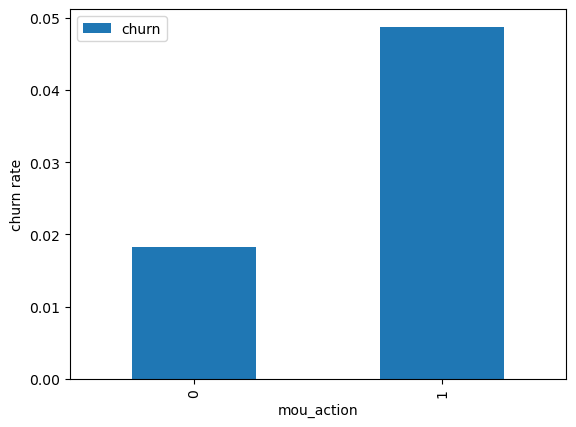

In [103]:
dataset1.pivot_table(values='churn', index='mou_action', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

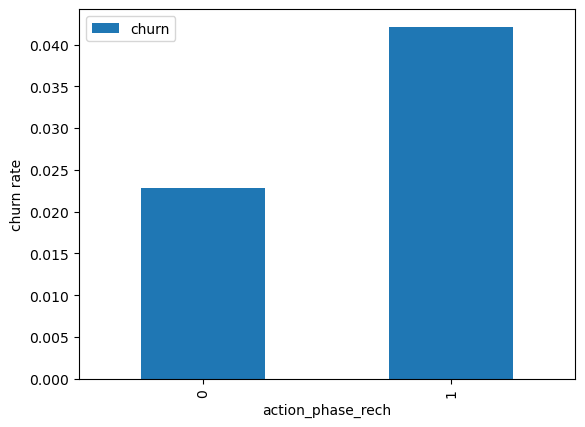

In [104]:
dataset1.pivot_table(values='churn', index='action_phase_rech', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

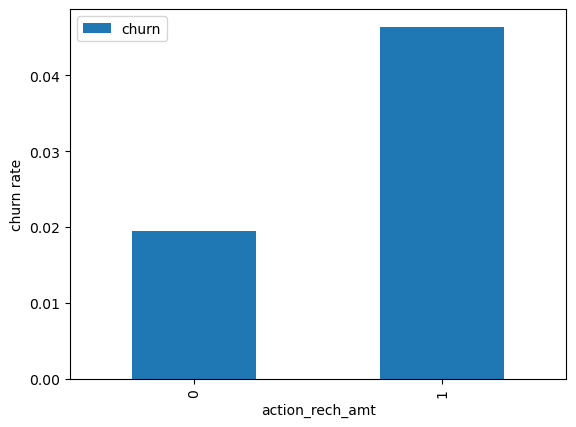

In [105]:
dataset1.pivot_table(values='churn', index='action_rech_amt', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

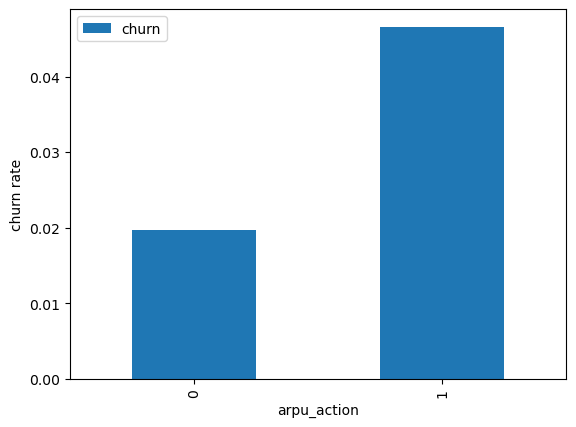

In [106]:
dataset1.pivot_table(values='churn', index='arpu_action', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

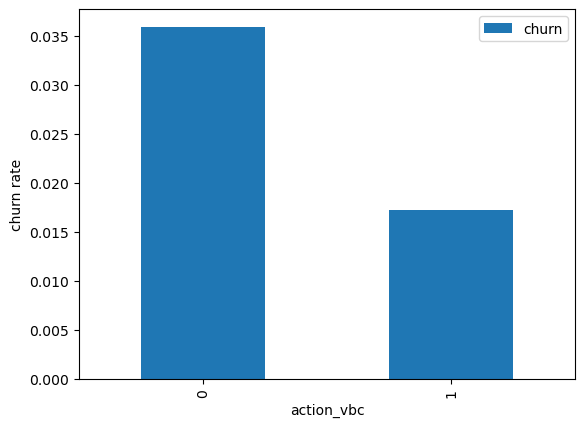

In [107]:
dataset1.pivot_table(values='churn', index='action_vbc', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

*Revenue generated for each customer*

In [109]:
data_churn1 = dataset1[dataset1['churn'] == 1]
# Creating not churn dataframe
data_churn0 = dataset1[dataset1['churn'] == 0]

[Text(0.5, 0, 'Action phase ARPU')]

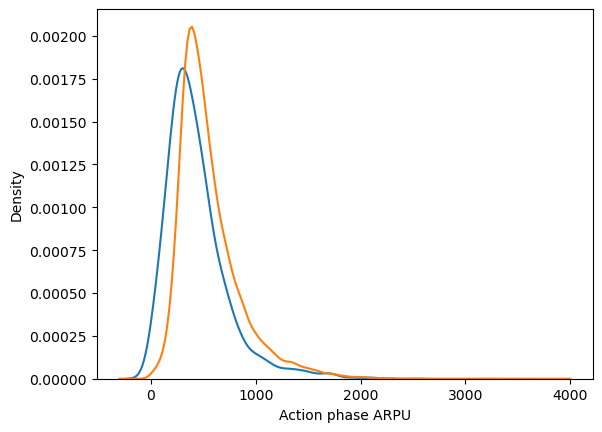

In [110]:
ax = sns.distplot(data_churn1['avg_arpu_action'],label='churn',hist=False)
ax = sns.distplot(data_churn0['avg_arpu_action'],label='not churn',hist=False)
ax.set(xlabel='Action phase ARPU')

MOU for churn and non-churn cust during action phase

[Text(0.5, 0, 'Action phase MOU')]

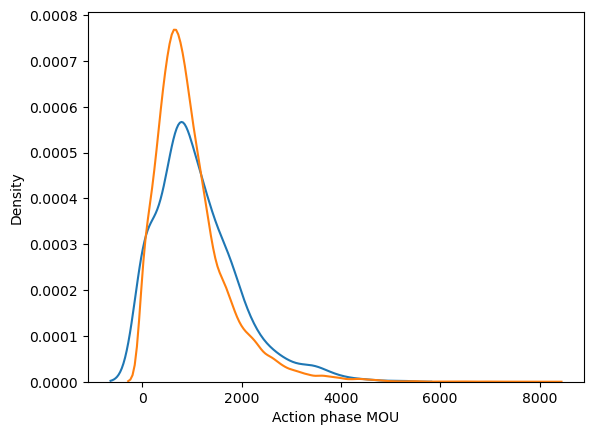

In [112]:
ax = sns.distplot(data_churn1['total_mou_good'],label='churn',hist=False)
ax = sns.distplot(data_churn0['total_mou_good'],label='non churn',hist=False)
ax.set(xlabel='Action phase MOU')

### Bivariate Analysis

Analysis of churn rate

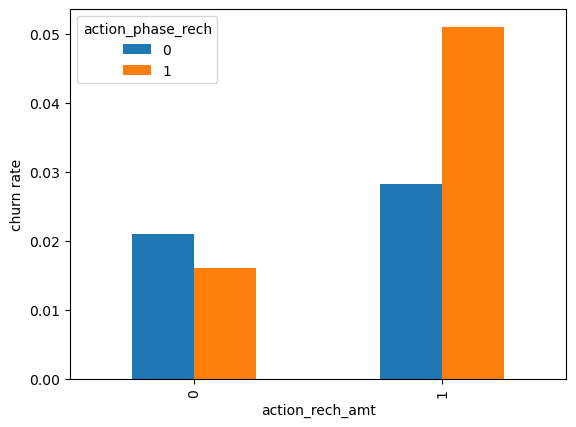

In [115]:
dataset1.pivot_table(values='churn', index='action_rech_amt', columns='action_phase_rech', aggfunc='mean').plot.bar()
plt.ylabel('churn rate')
plt.show()

Customers with decreasing reacharge amount and rate it which they recharge is more likely to churn in the action phase

In [117]:
dataset1 = dataset1.drop(['total_mou_good','avg_mou_action','diff_mou','avg_rech_num_action','diff_rech_num','avg_rech_amt_action',
                 'diff_rech_amt','avg_arpu_action','diff_arpu','avg_vbc_3g_action','diff_vbc','avg_rech_amt_6_7'], axis=1)

## Test-Train Split

In [119]:
from sklearn.model_selection import train_test_split

In [120]:
X = dataset1.drop(['mobile_number','churn'], axis=1)

In [121]:
y = dataset1['churn']

In [122]:
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=100)

Dealing with data imbalance

In [124]:
SMT = SMOTE(random_state=27)

In [125]:
X_train, y_train = SMT.fit_resample(X_train, y_train)

Standardization

In [127]:
SC = StandardScaler()

In [128]:
cols_scale = X_train.columns.to_list()
# Removing the derived binary columns 
cols_scale.remove('mou_action')
cols_scale.remove('action_phase_rech')
cols_scale.remove('action_rech_amt')
cols_scale.remove('arpu_action')
cols_scale.remove('action_vbc')

In [129]:
X_train[cols_scale] = SC.fit_transform(X_train[cols_scale])

In [130]:
X_train.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,mou_action,action_phase_rech,action_rech_amt,arpu_action,action_vbc
0,0.0,0.0,0.0,0.140777,-0.522792,-0.276289,0.106540,-0.662084,-0.465777,-0.211202,...,-0.113882,-0.361238,-0.236209,-0.265392,0.110582,1,1,1,1,1
1,0.0,0.0,0.0,-1.427243,4.428047,3.254270,-0.658491,-0.236590,-0.004450,-0.776075,...,-0.113882,-0.790173,-0.255884,-0.265392,-0.259366,0,0,0,0,0
2,0.0,0.0,0.0,-0.222751,0.543206,0.809117,-0.601239,-0.599206,-0.331043,-0.363395,...,2.526725,1.571302,3.307334,2.691063,1.700218,1,0,0,0,0
3,0.0,0.0,0.0,-0.911173,0.842273,0.731302,-0.702232,-0.650471,-0.458464,-0.789784,...,-0.113882,-0.951024,-0.255884,-0.265392,-0.259366,0,0,0,0,0
4,0.0,0.0,0.0,0.271356,0.247684,1.256421,-0.356392,-0.180394,0.114727,0.899204,...,-0.113882,-0.519757,-0.255884,-0.265392,-0.259366,0,0,0,0,0


In [131]:
X_test[cols_scale] = SC.transform(X_test[cols_scale])
X_test.head()

,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,arpu_6,arpu_7,arpu_8,onnet_mou_6,onnet_mou_7,onnet_mou_8,offnet_mou_6,...,sachet_3g_8,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,mou_action,action_phase_rech,action_rech_amt,arpu_action,action_vbc
5704,0.0,0.0,0.0,0.244310,-0.268832,1.005890,-0.725286,-0.690223,-0.476634,0.483540,...,2.526725,0.225051,0.018023,0.194794,-0.259366,0,0,1,1,0
64892,0.0,0.0,0.0,0.048359,-0.779609,-0.157969,-0.734066,-0.698072,-0.502219,-0.358555,...,-0.113882,0.622516,2.423668,2.357564,5.861151,1,1,1,1,1
39613,0.0,0.0,0.0,0.545470,0.184388,1.403349,-0.537110,-0.521615,-0.206890,0.694901,...,-0.113882,2.966507,-0.255884,-0.265392,-0.259366,1,1,1,0,0
93118,0.0,0.0,0.0,0.641508,0.816632,-0.211023,-0.058843,0.029897,-0.155872,-0.148197,...,-0.113882,1.742643,-0.255884,-0.265392,-0.259366,1,0,1,1,0
81235,0.0,0.0,0.0,3.878627,0.911619,2.745295,4.117829,1.452446,2.809582,-0.002634,...,1.206422,-0.244679,-0.255884,-0.265392,-0.259366,1,1,1,1,0


### 5. Principal Component Analysis (PCA) Model

In [133]:
pca = PCA(random_state=42)

In [134]:
pca.fit(X_train)

PCA(random_state=42)

In [135]:
pca.components_

array([[-7.50315936e-20,  1.38777878e-17, -2.22044605e-16, ...,
        -2.59799614e-02, -2.57740516e-02,  1.40032998e-02],
       [-1.61507486e-19,  2.77555756e-17,  0.00000000e+00, ...,
        -1.16737642e-02, -9.94022864e-03, -1.42598315e-02],
       [ 1.91332162e-19,  2.77555756e-17,  2.49800181e-16, ...,
        -4.18532955e-02, -4.28357226e-02,  2.46812846e-02],
       ...,
       [ 0.00000000e+00,  2.70235277e-03,  9.47762269e-02, ...,
         1.60461922e-17, -2.34187669e-17, -2.77555756e-17],
       [ 0.00000000e+00,  1.37603382e-01,  2.16382850e-02, ...,
        -4.85722573e-17, -4.68375339e-17, -2.77555756e-17],
       [ 9.99999470e-01,  9.12536933e-04, -4.47890749e-04, ...,
         1.21972744e-19,  5.62429877e-19, -1.90955108e-17]])

In [136]:
variance_cumu = np.cumsum(pca.explained_variance_ratio_)
print(variance_cumu)

[0.11213256 0.19426234 0.24575583 0.28953571 0.32841891 0.36623473
 0.40173361 0.43144425 0.45702167 0.48194328 0.50480575 0.52673812
 0.54724457 0.5670202  0.58530008 0.60304258 0.6190213  0.63473458
 0.64927873 0.66341423 0.67712828 0.69025011 0.7020618  0.71278516
 0.72309435 0.73290234 0.74255604 0.75209676 0.76151565 0.77010093
 0.77861315 0.7866115  0.79429496 0.80173555 0.80878909 0.81538157
 0.82193734 0.8283476  0.83472622 0.84089758 0.84687761 0.85280024
 0.85840083 0.86374029 0.86901646 0.87418749 0.87891437 0.88341796
 0.887723   0.89186057 0.89588256 0.89966074 0.90339384 0.90704071
 0.91060084 0.91411689 0.91752343 0.92076319 0.92395413 0.92705111
 0.93001239 0.93296077 0.93580029 0.93862291 0.94138851 0.9441162
 0.94678675 0.94937767 0.95188405 0.95433786 0.95665036 0.95893735
 0.96116409 0.96323063 0.96526039 0.967203   0.96912626 0.97100138
 0.97284931 0.9746657  0.97639261 0.97806622 0.97972617 0.98133794
 0.98290963 0.98446566 0.98601222 0.98753485 0.98877905 0.98998

Text(0, 0.5, 'Cumulative Variance')

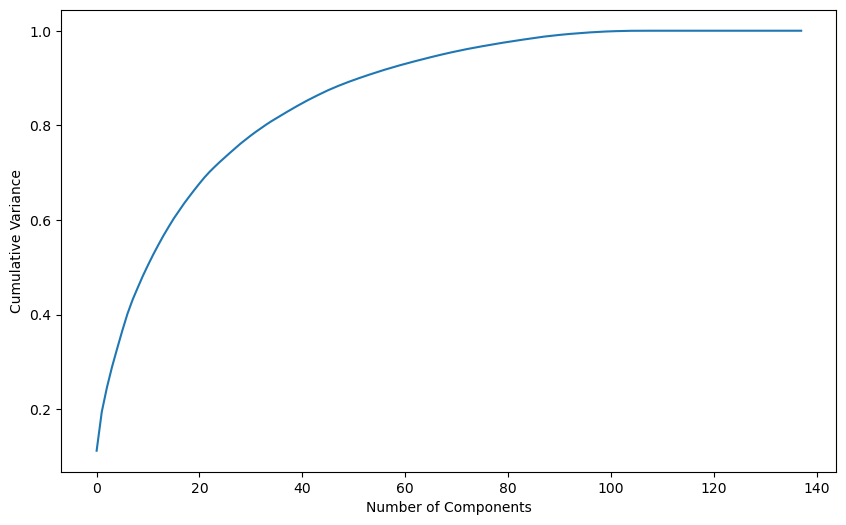

In [137]:
fig = plt.figure(figsize = (10,6))
plt.plot(variance_cumu)
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Variance')

In [138]:
pca_final = IncrementalPCA(n_components=60)

In [139]:
X_train_pca = pca_final.fit_transform(X_train)

In [140]:
X_test_pca = pca_final.transform(X_test)

Emphasize Sensitivity/Recall than Accuracy
We are more focused on higher Sensitivity/Recall score than the accuracy.

Beacuse we need to care more about churn cases than the not churn cases. The main goal is to reatin the customers, who have the possiblity to churn. There should not be a problem, if we consider few not churn customers as churn customers and provide them some incentives for retaining them. Hence, the sensitivity score is more important here.

Logistic regression with PCA

Tuning hyperparameter C

C is the the inverse of regularization strength in Logistic Regression. Higher values of C correspond to less regularization.

In [144]:
folds = KFold(n_splits=5, shuffle=True, random_state=4)

# Specify params
params = {"C": [0.01, 0.1, 1, 10, 100, 1000]}

# Specifing score as recall as we are more focused on acheiving the higher sensitivity than the accuracy
model_cv = GridSearchCV(estimator = LogisticRegression(),
                        param_grid = params, 
                        scoring= 'recall', 
                        cv = folds, 
                        verbose = 1,
                        return_train_score=True) 

# Fit the model
model_cv.fit(X_train_pca, y_train)

Fitting 5 folds for each of 6 candidates, totalling 30 fits


GridSearchCV(cv=KFold(n_splits=5, random_state=4, shuffle=True),
             estimator=LogisticRegression(),
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000]},
             return_train_score=True, scoring='recall', verbose=1)

In [145]:
cv_results = pd.DataFrame(model_cv.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_C,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.359645,0.018914,0.013968,0.004386,0.01,{'C': 0.01},0.900071,0.897759,0.895814,0.906425,...,0.897524,0.006134,5,0.901116,0.898256,0.899387,0.895440,0.897971,0.898434,0.001861
1,0.631631,0.008305,0.015624,0.000003,0.1,{'C': 0.1},0.898177,0.896359,0.894651,0.905959,...,0.896910,0.005390,6,0.901174,0.898431,0.899270,0.896725,0.899257,0.898971,0.001440
2,0.689874,0.021437,0.014063,0.003795,1,{'C': 1},0.898650,0.898693,0.895581,0.905028,...,0.897656,0.004783,4,0.901988,0.898606,0.898861,0.898184,0.899199,0.899368,0.001351
3,0.787664,0.008373,0.013753,0.004811,10,{'C': 10},0.898887,0.898459,0.896744,0.904562,...,0.897704,0.004719,3,0.902511,0.898956,0.898394,0.898476,0.899550,0.899577,0.001524
4,0.709386,0.043954,0.015132,0.002674,100,{'C': 100},0.899597,0.898226,0.896977,0.904330,...,0.897892,0.004528,1,0.902628,0.898722,0.898569,0.898593,0.899608,0.899624,0.001550
5,0.673811,0.045498,0.018415,0.005111,1000,{'C': 1000},0.899597,0.898226,0.896977,0.904330,...,0.897892,0.004528,1,0.902628,0.898839,0.898686,0.898593,0.899608,0.899671,0.001521


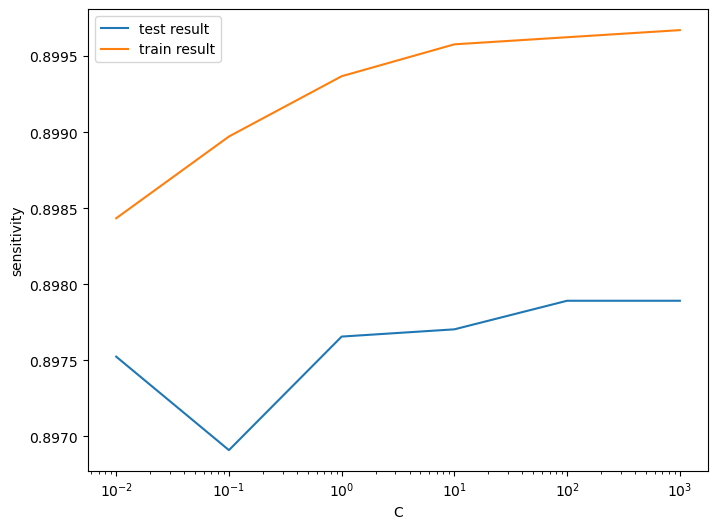

In [146]:
plt.figure(figsize=(8, 6))
plt.plot(cv_results['param_C'], cv_results['mean_test_score'])
plt.plot(cv_results['param_C'], cv_results['mean_train_score'])
plt.xlabel('C')
plt.ylabel('sensitivity')
plt.legend(['test result', 'train result'], loc='upper left')
plt.xscale('log')

In [147]:
best_score = model_cv.best_score_
best_C = model_cv.best_params_['C']

print(" The highest test sensitivity is {0} at C = {1}".format(best_score, best_C))

 The highest test sensitivity is 0.8978916608693863 at C = 100


**Logistic regression with optimal C**

In [149]:
logistic_pca = LogisticRegression(C=best_C)

In [150]:
log_pca_model = logistic_pca.fit(X_train_pca, y_train)

**Prediction on train set**

In [152]:
y_train_pred = log_pca_model.predict(X_train_pca)

In [153]:
confusion = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion)

[[17908  3517]
 [ 2154 19271]]


In [154]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [155]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8676546091015169
Sensitivity:- 0.899463243873979
Specificity:- 0.8358459743290548


Prediction on test set

In [157]:
# Prediction on the test set
y_test_pred = log_pca_model.predict(X_test_pca)

In [158]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[4452  896]
 [  36  157]]


In [159]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [160]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8317993142032124
Sensitivity:- 0.8134715025906736
Specificity:- 0.8324607329842932


- Model summary

Train set

    Accuracy = 0.86
    Sensitivity = 0.89
    Specificity = 0.83

Test set

    Accuracy = 0.83
    Sensitivity = 0.81
    Specificity = 0.83
    
Overall, the model is performing well in the test set, what it had learnt from the train set.

### 6. Decision tree with PCA

Hyperparameter tuning

In [164]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(50, 150, 50),
    'min_samples_split': range(50, 150, 50),
}


# Instantiate the grid search model
dtree = DecisionTreeClassifier()

grid_search = GridSearchCV(estimator = dtree, 
                           param_grid = param_grid, 
                           scoring= 'recall',
                           cv = 5, 
                           verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_train_pca,y_train)

Fitting 5 folds for each of 8 candidates, totalling 40 fits


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(50, 150, 50),
                         'min_samples_split': range(50, 150, 50)},
             scoring='recall', verbose=1)

In [165]:
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,param_min_samples_leaf,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,3.574554,0.144284,0.010708,0.006648,5,50,50,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.862310,0.855776,0.878413,0.875379,0.855309,0.865438,0.009725,5
1,3.513230,0.144757,0.015627,0.009880,5,50,100,"{'max_depth': 5, 'min_samples_leaf': 50, 'min_...",0.862310,0.855776,0.878413,0.875379,0.855309,0.865438,0.009725,5
2,3.501459,0.193582,0.016510,0.002281,5,100,50,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.858110,0.855309,0.875846,0.869078,0.849008,0.861470,0.009686,8
3,3.263872,0.045264,0.019417,0.006136,5,100,100,"{'max_depth': 5, 'min_samples_leaf': 100, 'min...",0.858110,0.855309,0.875846,0.869078,0.849475,0.861564,0.009567,7
4,5.667974,0.273440,0.018275,0.006769,10,50,50,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.886114,0.894516,0.903851,0.905484,0.913652,0.900723,0.009503,1
5,5.695197,0.337935,0.015202,0.000842,10,50,100,"{'max_depth': 10, 'min_samples_leaf': 50, 'min...",0.886114,0.894516,0.903851,0.905484,0.912485,0.900490,0.009192,2
6,5.644198,0.125136,0.015675,0.000116,10,100,50,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.889615,0.871179,0.875613,0.891949,0.883781,0.882427,0.007964,3
7,5.465725,0.180504,0.015763,0.002931,10,100,100,"{'max_depth': 10, 'min_samples_leaf': 100, 'mi...",0.889615,0.869778,0.875613,0.891949,0.884247,0.882240,0.008389,4


In [166]:
# Printing the optimal sensitivity score and hyperparameters
print("Best sensitivity:-", grid_search.best_score_)
print(grid_search.best_estimator_)

Best sensitivity:- 0.9007234539089849
DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50)


**Model with optimal hyperparameters**

In [168]:
# Model with optimal hyperparameters
dt_pca_model = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=10, 
                                  min_samples_leaf=50,
                                  min_samples_split=50)

dt_pca_model.fit(X_train_pca, y_train)

DecisionTreeClassifier(max_depth=10, min_samples_leaf=50, min_samples_split=50,
                       random_state=100)

**Prediction on the train set**

In [170]:
# Predictions on the train set
y_train_pred = dt_pca_model.predict(X_train_pca)

In [171]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_train, y_train_pred)
print(confusion)

[[18913  2512]
 [ 1763 19662]]


In [172]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [173]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train, y_train_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.9002333722287048
Sensitivity:- 0.9177129521586931
Specificity:- 0.8827537922987164


**Prediction on the test set**

In [175]:
# Prediction on the test set
y_test_pred = dt_pca_model.predict(X_test_pca)

In [176]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test, y_test_pred)
print(confusion)

[[4632  716]
 [  58  135]]


In [177]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [178]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test, y_test_pred))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8603140227395777
Sensitivity:- 0.6994818652849741
Specificity:- 0.8661181750186986


Model summary

Train set

    Accuracy = 0.90
    Sensitivity = 0.91
    Specificity = 0.88

Test set

    Accuracy = 0.86
    Sensitivity = 0.70
    Specificity = 0.87
    
We can see from the model performance that the Sesitivity has been decreased while evaluating the model on the test set. However, the accuracy and specificity is quite good in the test set.

### 6. Model building without PCA

#### 6.1 Logistic regression with No PCA

In [182]:
no_pca = sm.GLM(y_train,(sm.add_constant(X_train)), family=sm.families.Binomial())

In [183]:
no_pca = no_pca.fit().summary()

In [184]:
no_pca

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                42850
Model:                            GLM   Df Residuals:                    42720
Model Family:                Binomial   Df Model:                          129
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 06 Jan 2025   Deviance:                       23572.
Time:                        05:38:05   Pearson chi2:                 3.70e+05
No. Iterations:                   100   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                -57.0615   4420.876     -0.013      0.990   -8721.819    8607.696
loc_og_t2o_mou     -1.678e-06      0.000     -0.011      0.991      -0.000       0.000
std_og_t2o_mou       3.35e-07   5.18e-05      0.006      0.995      -0.000       0.000
loc_ic_t2o_mou      -3.19e-06      0.000     -0.013      0.990      -0.000       0.000
arpu_6                -0.0338      0.081     -0.418      0.676      -0.192       0.125
arpu_7                 0.0855      0.086      0.993      0.320      -0.083       0.254
arpu_8                 0.0907      0.110      0.826      0.409      -0.125       0.306
onnet_mou_6           15.5096      3.588      4.323      0.000       8.478      22.541
onnet_mou_7           -4.3249      1.831     -2.362      0.018      -7.914      -0.736
onnet_mou_8            2.3519      1.839      1.279      0.201      -1.252       5.956
offnet_mou_6          15.0838      3.375      4.470      0.000       8.469      21.698
offnet_mou_7          -1.7633      1.735     -1.016      0.310      -5.164       1.637
offnet_mou_8          -0.5505      1.897     -0.290      0.772      -4.269       3.168
roam_ic_mou_6          0.1622      0.037      4.434      0.000       0.091       0.234
roam_ic_mou_7         -0.0100      0.053     -0.189      0.850      -0.114       0.094
roam_ic_mou_8          0.2042      0.044      4.641      0.000       0.118       0.290
roam_og_mou_6         -5.1495      1.136     -4.534      0.000      -7.375      -2.924
roam_og_mou_7          0.8855      0.478      1.853      0.064      -0.051       1.822
roam_og_mou_8          0.0930      0.535      0.174      0.862      -0.955       1.141
loc_og_t2t_mou_6   -3302.7242    657.274     -5.025      0.000   -4590.957   -2014.491
loc_og_t2t_mou_7   -1474.7070    680.656     -2.167      0.030   -2808.768    -140.646
loc_og_t2t_mou_8    5515.8194    628.513      8.776      0.000    4283.957    6747.682
loc_og_t2m_mou_6   -3342.3442    665.039     -5.026      0.000   -4645.796   -2038.892
loc_og_t2m_mou_7   -1392.1921    641.927     -2.169      0.030   -2650.347    -134.038
loc_og_t2m_mou_8    5887.0564    670.647      8.778      0.000    4572.613    7201.500
loc_og_t2f_mou_6    -285.2161     56.787     -5.023      0.000    -396.517    -173.915
loc_og_t2f_mou_7    -123.0240     56.749     -2.168      0.030    -234.251     -11.797
loc_og_t2f_mou_8     487.3721     55.550      8.774      0.000     378.496     596.248
loc_og_t2c_mou_6       0.0433      0.022      1.970      0.049       0.000       0.086
loc_og_t2c_mou_7       0.0100      0.022      0.459      0.646      -0.033       0.053
loc_og_t2c_mou_8       0.0673      0.023      2.958      0.003       0.023       0.112
loc_og_mou_6        3756.0531   1270.900      2.955      0.003    1265.134    6246.972
loc_og_mou_7        5685.9791   1331.5

Model analysis

- We noticed that there is a combination of positive and negative coefficients
- Most features have high -value making it insignificant in the model

Coarse tuning (Auto+Manual)

Let us try eliminating few feature using RFE. We can then manually eliminate more features with smaller set of variables

Feature Selection Using RFE

In [187]:
logreg = LogisticRegression()

RFE with 15 columns

In [189]:
rfe1 = RFE(estimator=logreg, n_features_to_select=15)

# Fit the rfe model with train set
rfe1 = rfe1.fit(X_train, y_train)

In [190]:
# RFE selected columns
rfe_cols = X_train.columns[rfe1.support_]
print(rfe_cols)

Index(['offnet_mou_7', 'offnet_mou_8', 'roam_og_mou_8', 'std_og_t2m_mou_8',
       'isd_og_mou_8', 'og_others_7', 'og_others_8', 'loc_ic_t2f_mou_8',
       'loc_ic_mou_8', 'std_ic_t2f_mou_8', 'ic_others_8', 'total_rech_num_8',
       'monthly_2g_8', 'monthly_3g_8', 'action_vbc'],
      dtype='object')


Model-1 with RFE selected columns

In [192]:
# Adding constant to X_train
X_train_sm_1 = sm.add_constant(X_train[rfe_cols])

#Instantiate the model
log_no_pca_1 = sm.GLM(y_train, X_train_sm_1, family=sm.families.Binomial())

# Fit the model
log_no_pca_1 = log_no_pca_1.fit()

log_no_pca_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                42850
Model:                            GLM   Df Residuals:                    42834
Model Family:                Binomial   Df Model:                           15
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                    nan
Date:                Mon, 06 Jan 2025   Deviance:                       30008.
Time:                        05:40:11   Pearson chi2:                 4.49e+06
No. Iterations:                    41   Pseudo R-squ. (CS):                nan
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const              -53.0128   4235.111     -0.013      0.990   -8353.678    8247.652
offnet_mou_7         0.6096      0.026     23.449      0.000       0.559       0.661
offnet_mou_8        -3.2532      0.106    -30.548      0.000      -3.462      -3.045
roam_og_mou_8        1.2482      0.032     39.496      0.000       1.186       1.310
std_og_t2m_mou_8     2.4408      0.094     26.101      0.000       2.258       2.624
isd_og_mou_8        -1.0212      0.194     -5.271      0.000      -1.401      -0.641
og_others_7         -1.1915      0.862     -1.382      0.167      -2.881       0.498
og_others_8      -3780.7239   3.08e+05     -0.012      0.990   -6.08e+05    6.01e+05
loc_ic_t2f_mou_8    -0.7547      0.072    -10.487      0.000      -0.896      -0.614
loc_ic_mou_8        -1.9744      0.066    -30.078      0.000      -2.103      -1.846
std_ic_t2f_mou_8    -0.7922      0.075    -10.607      0.000      -0.939      -0.646
ic_others_8         -1.4913      0.132    -11.305      0.000      -1.750      -1.233
total_rech_num_8    -0.4840      0.018    -26.977      0.000      -0.519      -0.449
monthly_2g_8        -0.9031      0.043    -20.851      0.000      -0.988      -0.818
monthly_3g_8        -0.9871      0.043    -22.711      0.000      -1.072      -0.902
action_vbc          -1.3078      0.073    -17.956      0.000      -1.451      -1.165
====================================================================================
"""

Checking VIFs

In [194]:
# Datafram with names of all the features and their vifs
vif = pd.DataFrame()
vif['Features'] = X_train[rfe_cols].columns
vif['VIF'] = [variance_inflation_factor(X_train[rfe_cols].values, i) for i in range(X_train[rfe_cols].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,offnet_mou_8,7.45
3,std_og_t2m_mou_8,6.27
0,offnet_mou_7,1.92
8,loc_ic_mou_8,1.68
7,loc_ic_t2f_mou_8,1.21
11,total_rech_num_8,1.19
2,roam_og_mou_8,1.16
14,action_vbc,1.08
13,monthly_3g_8,1.06
6,og_others_8,1.05


**Column og_others_8, which is insignificatnt as it has the highest p-value 0.99**

In [196]:
# Removing og_others_8 column 
cols1 = rfe_cols.to_list()
cols1.remove('og_others_8')
print(cols1)

['offnet_mou_7', 'offnet_mou_8', 'roam_og_mou_8', 'std_og_t2m_mou_8', 'isd_og_mou_8', 'og_others_7', 'loc_ic_t2f_mou_8', 'loc_ic_mou_8', 'std_ic_t2f_mou_8', 'ic_others_8', 'total_rech_num_8', 'monthly_2g_8', 'monthly_3g_8', 'action_vbc']


##### Model-2

Building the model after removing og_others_8 variable.

In [198]:
# Adding constant to X_train
X_train_sm_2 = sm.add_constant(X_train[cols1])

#Instantiate the model
no_pca_2 = sm.GLM(y_train, X_train_sm_2, family=sm.families.Binomial())

# Fit the model
no_pca_2 = no_pca_2.fit()

no_pca_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                42850
Model:                            GLM   Df Residuals:                    42835
Model Family:                Binomial   Df Model:                           14
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15034.
Date:                Mon, 06 Jan 2025   Deviance:                       30068.
Time:                        05:40:13   Pearson chi2:                 4.51e+06
No. Iterations:                    11   Pseudo R-squ. (CS):             0.4957
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.1052      0.031    -35.342      0.000      -1.167      -1.044
offnet_mou_7         0.6081      0.026     23.427      0.000       0.557       0.659
offnet_mou_8        -3.2557      0.106    -30.603      0.000      -3.464      -3.047
roam_og_mou_8        1.2491      0.031     39.747      0.000       1.188       1.311
std_og_t2m_mou_8     2.4428      0.093     26.146      0.000       2.260       2.626
isd_og_mou_8        -1.0982      0.196     -5.590      0.000      -1.483      -0.713
og_others_7         -1.8793      0.818     -2.299      0.022      -3.482      -0.277
loc_ic_t2f_mou_8    -0.7548      0.072    -10.491      0.000      -0.896      -0.614
loc_ic_mou_8        -1.9714      0.066    -30.058      0.000      -2.100      -1.843
std_ic_t2f_mou_8    -0.8020      0.075    -10.727      0.000      -0.949      -0.655
ic_others_8         -1.4871      0.132    -11.278      0.000      -1.746      -1.229
total_rech_num_8    -0.4864      0.018    -27.146      0.000      -0.522      -0.451
monthly_2g_8        -0.9066      0.043    -20.866      0.000      -0.992      -0.821
monthly_3g_8        -0.9862      0.043    -22.700      0.000      -1.071      -0.901
action_vbc          -1.3097      0.073    -17.994      0.000      -1.452      -1.167
====================================================================================
"""

Checking VIF for Model-2

In [200]:
# Create a dataframe that will contain the names of all the feature variables and their respective VIFs
vif = pd.DataFrame()
vif['Features'] = X_train[cols1].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols1].values, i) for i in range(X_train[cols1].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
1,offnet_mou_8,7.45
3,std_og_t2m_mou_8,6.27
0,offnet_mou_7,1.92
7,loc_ic_mou_8,1.68
6,loc_ic_t2f_mou_8,1.21
10,total_rech_num_8,1.19
2,roam_og_mou_8,1.16
13,action_vbc,1.08
12,monthly_3g_8,1.06
11,monthly_2g_8,1.05


**offnet_mou_8 has the highest VIF so need to remove this column**

In [202]:
# Removing offnet_mou_8 column
cols1.remove('offnet_mou_8')

##### Model-3

Model after removing offnet_mou_8 column.

In [204]:
# Adding constant to X_train
X_train_sm_3 = sm.add_constant(X_train[cols1])

#Instantiate the model
no_pca_3 = sm.GLM(y_train, X_train_sm_3, family=sm.families.Binomial())

# Fit the model
no_pca_3 = no_pca_3.fit()

no_pca_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  churn   No. Observations:                42850
Model:                            GLM   Df Residuals:                    42836
Model Family:                Binomial   Df Model:                           13
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -15720.
Date:                Mon, 06 Jan 2025   Deviance:                       31440.
Time:                        05:40:15   Pearson chi2:                 3.92e+06
No. Iterations:                    11   Pseudo R-squ. (CS):             0.4793
Covariance Type:            nonrobust                                         
====================================================================================
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               -1.2058      0.032    -37.536      0.000      -1.269      -1.143
offnet_mou_7         0.3665      0.022     16.456      0.000       0.323       0.410
roam_og_mou_8        0.7135      0.024     29.260      0.000       0.666       0.761
std_og_t2m_mou_8    -0.2474      0.022    -11.238      0.000      -0.291      -0.204
isd_og_mou_8        -1.3811      0.212     -6.511      0.000      -1.797      -0.965
og_others_7         -2.4711      0.872     -2.834      0.005      -4.180      -0.762
loc_ic_t2f_mou_8    -0.7102      0.075     -9.532      0.000      -0.856      -0.564
loc_ic_mou_8        -3.3287      0.057    -58.130      0.000      -3.441      -3.216
std_ic_t2f_mou_8    -0.9503      0.078    -12.181      0.000      -1.103      -0.797
ic_others_8         -1.5131      0.129    -11.771      0.000      -1.765      -1.261
total_rech_num_8    -0.5060      0.018    -28.808      0.000      -0.540      -0.472
monthly_2g_8        -0.9279      0.044    -21.027      0.000      -1.014      -0.841
monthly_3g_8        -1.0943      0.046    -23.615      0.000      -1.185      -1.004
action_vbc          -1.3293      0.072    -18.478      0.000      -1.470      -1.188
====================================================================================
"""

VIF Model-3

In [206]:
vif = pd.DataFrame()
vif['Features'] = X_train[cols1].columns
vif['VIF'] = [variance_inflation_factor(X_train[cols1].values, i) for i in range(X_train[cols1].shape[1])]
vif['VIF'] = round(vif['VIF'], 2)
vif = vif.sort_values(by = "VIF", ascending = False)
vif

,Features,VIF
2,std_og_t2m_mou_8,1.87
0,offnet_mou_7,1.72
6,loc_ic_mou_8,1.33
5,loc_ic_t2f_mou_8,1.21
9,total_rech_num_8,1.17
12,action_vbc,1.07
1,roam_og_mou_8,1.06
11,monthly_3g_8,1.06
10,monthly_2g_8,1.05
7,std_ic_t2f_mou_8,1.02


**Our final model will be no_pca_3, given the VIF of all variables are significant and there dont seem to be any multicollinearity among them**

### Model performance on the train set

In [209]:
# Getting the predicted value on the train set
y_train_pred_no_pca = no_pca_3.predict(X_train_sm_3)
y_train_pred_no_pca.head()

0    2.687411e-01
1    7.047483e-02
2    8.024370e-02
3    3.439222e-03
4    5.253815e-19
dtype: float64

Creating a dataframe with the actual churn and the predicted probabilities

In [211]:
y_train_predf = pd.DataFrame({'churn':y_train.values, 'churn_prob':y_train_pred_no_pca.values})

#Assigning Customer ID for each record for better readblity
#CustID is the index of each record.
y_train_predf['CustID'] = y_train_predf.index

y_train_predf.head()

,churn,churn_prob,CustID
0,0,2.687411e-01,0
1,0,7.047483e-02,1
2,0,8.024370e-02,2
3,0,3.439222e-03,3
4,0,5.253815e-19,4


**Finding Optimal Probablity Cutoff Point**

In [213]:
# Creating columns for different probablity cutoffs
cutoff_probability = [float(p/10) for p in range(10)]

for i in cutoff_probability:
    y_train_predf[i] = y_train_predf['churn_prob'].map(lambda x : 1 if x > i else 0)
    
y_train_predf.head()

,churn,churn_prob,CustID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9
0,0,2.687411e-01,0,1,1,1,0,0,0,0,0,0,0
1,0,7.047483e-02,1,1,0,0,0,0,0,0,0,0,0
2,0,8.024370e-02,2,1,0,0,0,0,0,0,0,0,0
3,0,3.439222e-03,3,1,0,0,0,0,0,0,0,0,0
4,0,5.253815e-19,4,1,0,0,0,0,0,0,0,0,0


**Calculating the accuracy sensitivity and specificity for various probability cutoffs**

In [215]:
# Creating a dataframe
cutoff_dataf = pd.DataFrame(columns=['probability', 'accuracy', 'sensitivity', 'specificity'])

for i in cutoff_probability:
    cm1 = metrics.confusion_matrix(y_train_predf['churn'], y_train_predf[i] )
    total1=sum(sum(cm1))
    accuracy = (cm1[0,0]+cm1[1,1])/total1
    
    speci = cm1[0,0]/(cm1[0,0]+cm1[0,1])
    sensi = cm1[1,1]/(cm1[1,0]+cm1[1,1])
    cutoff_dataf.loc[i] =[ i ,accuracy,sensi,speci]
print(cutoff_dataf)

     probability  accuracy  sensitivity  specificity
0.0          0.0  0.500000     1.000000     0.000000
0.1          0.1  0.753629     0.984411     0.522847
0.2          0.2  0.788751     0.964714     0.612789
0.3          0.3  0.812509     0.946371     0.678646
0.4          0.4  0.829638     0.923874     0.735403
0.5          0.5  0.844131     0.895823     0.792439
0.6          0.6  0.844271     0.839860     0.848681
0.7          0.7  0.836173     0.769522     0.902824
0.8          0.8  0.800163     0.652275     0.948051
0.9          0.9  0.595426     0.207001     0.983851


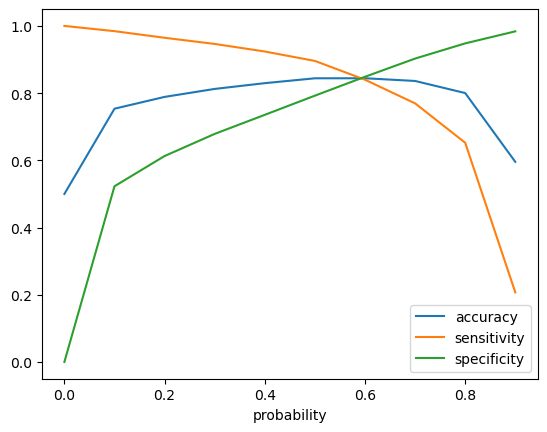

In [216]:
# Plotting accuracy, sensitivity and specificity for different probabilities.
cutoff_dataf.plot('probability', ['accuracy','sensitivity','specificity'])
plt.show()

Analysis of the above curve

     Accuracy - Becomes stable around 0.6

    Sensitivity - Decreases with the increased probablity.

    Specificity - Increases with the increasing probablity.


There seem to be a balance between sensitivty and specificity where three parameters intersect

In order to achieve greater sensitivity we are taking the probability cutoff as 0.5 instead of 0.6 as shown in figure

In [218]:
# Creating a column with name "predicted", which is the predicted value for 0.5 cutoff 
y_train_predf['predicted'] = y_train_predf['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)
y_train_predf.head()

,churn,churn_prob,CustID,0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,predicted
0,0,2.687411e-01,0,1,1,1,0,0,0,0,0,0,0,0
1,0,7.047483e-02,1,1,0,0,0,0,0,0,0,0,0,0
2,0,8.024370e-02,2,1,0,0,0,0,0,0,0,0,0,0
3,0,3.439222e-03,3,1,0,0,0,0,0,0,0,0,0,0
4,0,5.253815e-19,4,1,0,0,0,0,0,0,0,0,0,0


Metrics

In [220]:
# Confusion metrics
cm = metrics.confusion_matrix(y_train_predf['churn'], y_train_predf['predicted'])
print(cm)

[[16978  4447]
 [ 2232 19193]]


In [221]:
TP = cm[1,1] # true positive 
TN = cm[0,0] # true negatives
FP = cm[0,1] # false positives
FN = cm[1,0] # false negatives

In [222]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_train_predf['churn'], y_train_predf['predicted']))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.8441306884480747
Sensitivity:- 0.8958226371061844
Specificity:- 0.792438739789965


We now have the accuracy, sensitivity and specificity on the train set prediction

Plotting ROC Curve (Trade off between sensitivity & specificity)

In [224]:
# ROC Curve function

def draw_roc( actual, probs ):
    fpr, tpr, thresholds = metrics.roc_curve( actual, probs,
                                              drop_intermediate = False )
    auc_score = metrics.roc_auc_score( actual, probs )
    plt.figure(figsize=(5, 5))
    plt.plot( fpr, tpr, label='ROC curve (area = %0.2f)' % auc_score )
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate or [1 - True Negative Rate]')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

    return None

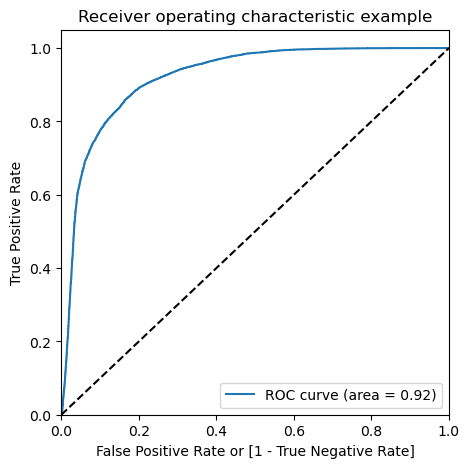

In [225]:
draw_roc(y_train_predf['churn'], y_train_predf['churn_prob'])

Testing the model on the test set

In [227]:
X_test_log = X_test.copy()

In [228]:
# Taking only the columns, which are selected in the train set after removing insignificant and multicollinear variables
X_test_log = X_test_log[cols1]

In [229]:
# Adding constant on the test set
X_test_sm = sm.add_constant(X_test_log)

In [230]:
# Predict on the test set
y_test_pred = no_pca_3.predict(X_test_sm)

In [231]:
y_test_pred.head()

5704     0.034015
64892    0.000578
39613    0.513564
93118    0.020480
81235    0.034115
dtype: float64

In [232]:

# Converting y_test_pred to a dataframe because y_test_pred is an array
y_pred1 = pd.DataFrame(y_test_pred)
y_pred1.head()

,0
5704,0.034015
64892,0.000578
39613,0.513564
93118,0.020480
81235,0.034115


In [233]:
# Convetting y_test to a dataframe
y_test_df = pd.DataFrame(y_test)
y_test_df.head()

,churn
5704,0
64892,0
39613,0
93118,0
81235,0


In [234]:
# Putting index to Customer ID 
y_test_df['CustID'] = y_test_df.index

In [235]:
# Removing index form the both dataframes for merging them side by side
y_pred1.reset_index(drop=True, inplace=True)
y_test_df.reset_index(drop=True, inplace=True)

In [236]:
# Appending y_pred_1 and y_test_df
y_test_predf = pd.concat([y_test_df, y_pred1], axis=1)

In [237]:
y_test_predf.head()

,churn,CustID,0
0,0,5704,0.034015
1,0,64892,0.000578
2,0,39613,0.513564
3,0,93118,0.020480
4,0,81235,0.034115


In [238]:
# Renaming the '0' column as churn probablity
y_test_predf = y_test_predf.rename(columns={0:'churn_prob'})

In [239]:
y_test_predf.head()

,churn,CustID,churn_prob
0,0,5704,0.034015
1,0,64892,0.000578
2,0,39613,0.513564
3,0,93118,0.020480
4,0,81235,0.034115


In [240]:
# In the test set using probablity cutoff 0.5, what we got in the train set 
y_test_predf['test_predicted'] = y_test_predf['churn_prob'].map(lambda x: 1 if x > 0.5 else 0)

In [241]:
y_test_predf.head()

,churn,CustID,churn_prob,test_predicted
0,0,5704,0.034015,0
1,0,64892,0.000578,0
2,0,39613,0.513564,1
3,0,93118,0.020480,0
4,0,81235,0.034115,0


Metrics

In [243]:
# Confusion matrix
confusion = metrics.confusion_matrix(y_test_predf['churn'], y_test_predf['test_predicted'])
print(confusion)

[[4190 1158]
 [  34  159]]


In [244]:
TP = confusion[1,1] # true positive 
TN = confusion[0,0] # true negatives
FP = confusion[0,1] # false positives
FN = confusion[1,0] # false negatives

In [245]:
# Accuracy
print("Accuracy:-",metrics.accuracy_score(y_test_predf['churn'], y_test_predf['test_predicted']))

# Sensitivity
print("Sensitivity:-",TP / float(TP+FN))

# Specificity
print("Specificity:-", TN / float(TN+FP))

Accuracy:- 0.7848763761053962
Sensitivity:- 0.8238341968911918
Specificity:- 0.7834704562453254


Model summary

Train set

    Accuracy = 0.84
    Sensitivity = 0.81
    Specificity = 0.83

Test set

    Accuracy = 0.78
    Sensitivity = 0.82
    Specificity = 0.78

Overall, the model is performing well in the test set, what it had learnt from the train set.

Final conclusion with no PCA


As compared to the model with PCA, the model without PCA has better sensitivity and accurracy.


Business recomendation

Top predictors

Below are few top variables selected in the logistic regression model.

Variables	Coefficients
    
    
    loc_ic_mou_8	    -3.3287
    og_others_7	        -2.4711
    ic_others_8	        -1.5131
    isd_og_mou_8	    -1.3811
    action_vbc	        -1.3293
    monthly_3g_8	    -1.0943
    std_ic_t2f_mou_8	-0.9503
    monthly_2g_8	    -0.9279
    loc_ic_t2f_mou_8	-0.7102
    roam_og_mou_8	     0.7135
   
We can see most of the top variables have negative coefficients. That means, the variables are inversely correlated with the churn probablity.



Recomendations

- Customers with less usage of local incoming and ISD outgoing calls in the action phase should be targetted

- Provide special offers to customers having their charges for value added services go up. They are most likely to churn

- Target customers with monthly 3g recharge go up during the action phase

- Customers with lesser monthly 2g usage during the action phase are likely to churn

- Customers whose roaming outgoing minutes have increased will most likely churn (given its coeffecient is positive)